<a href="https://colab.research.google.com/github/ZobayerAbedin/DeepLearning/blob/main/CharacterRecognition00_CNN%2BDataAugmentation_with_Google_Street_View_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import time
from torchsummary import summary
import cv2
from PIL import Image

import os
import copy
import zipfile
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data manupulation

In [121]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [122]:
# baseDir = '/content/gdrive/My Drive/Colab_Notebooks/Data/Char_Classification/'
baseDir = 'C:/Users/SM. Zobayer Abedin/Documents/DeepLearning/street-view-getting-started-with-julia/'

In [123]:
def dataExtraction(extractionDir, filePath):
    # Create the target directory if it does not exist
    if not os.path.exists(extractionDir):
        os.makedirs(extractionDir)

    try:
        with zipfile.ZipFile(filePath, "r") as zfile:
            zfile.extractall(extractionDir)
        print(f"Extraction complete. Files have been extracted to: {extractionDir}")

    except zipfile.BadZipFile:
        print(f"Error: '{filePath}' is not a valid ZIP file or may be corrupted.")

    except FileNotFoundError:
        print(f"Error: The file '{filePath}' does not exist.")

In [124]:
# dataExtraction(baseDir, baseDir + 'train.zip')
# dataExtraction(baseDir, baseDir + 'test.zip')

In [125]:
os.path.isdir(baseDir)

True

In [133]:
class ImageDataset(Dataset):
    def __init__(self, csvFile, imgDir, transform=None):
        self.labels = pd.read_csv(csvFile)
        self.imgDir = imgDir
        self.transform = transform

        # self.labels = self.labels.head(200)
        unq = sorted(self.labels['Class'].unique())
        self.toLabel = {char: i for i, char in enumerate(unq)}
        self.labels['Class'] = self.labels['Class'].map(self.toLabel)
        self.labels = self.labels.values.tolist()
        # print(self.labels, type(self.labels))



        # Load all images into memory using parallel processing
        self.images = [None] * len(self.labels)
        with ThreadPoolExecutor() as executor:
            executor.map(self.loadImage, range(len(self.labels)))

    def loadImage(self, idx):
        imgPath = os.path.join(self.imgDir, str(self.labels[idx][0]) + ".Bmp")

        image = Image.open(imgPath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        self.images[idx] = image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx][1]
        return image, label


In [127]:
imgSize = 32
transform = T.Compose([T.Resize((imgSize, imgSize)),
                       T.ToTensor()
                        ])

# # Load the dataset
# dataset = ImageDataset(baseDir + 'trainLabels.csv', baseDir + 'train', transform)

# # Initialize variables to store the sum and squared sum of pixel values
# # Initialize variables to store the sum and sum of squares of pixel values
# sum_rgb = np.zeros(3)
# sum_sq_rgb = np.zeros(3)
# num_pixels = 0

# # Iterate over each image in the dataset
# for image_tensor, _ in dataset:

#     # Update the sum and sum of squares
#     sum_rgb += image_tensor.sum(dim=(1, 2)).numpy()
#     sum_sq_rgb += (image_tensor ** 2).sum(dim=(1, 2)).numpy()

#     # Update the number of pixels
#     num_pixels += image_tensor.shape[1] * image_tensor.shape[2]

# # Calculate the mean and standard deviation
# mean_rgb = sum_rgb / num_pixels
# std_rgb = np.sqrt(sum_sq_rgb / num_pixels - mean_rgb ** 2)

# print(f'Mean: {mean_rgb}')
# print(f'Std: {std_rgb}')

In [128]:
mean_rgb = [0.51633593, 0.47992162, 0.45069369]
std_rgb = [0.25336818, 0.2420341,  0.25040966]

In [134]:
imgSize = 32
transform = T.Compose([T.Resize((imgSize, imgSize)),
                       T.ToTensor(),
                       T.Normalize(mean_rgb, std_rgb)
                       ])

dataset = ImageDataset(baseDir + 'trainLabels.csv', baseDir + 'train', transform)
torch.save(dataset, baseDir + 'charDatasetTrain.pt')

# torch.serialization.add_safe_globals([ImageDataset, Compose, Resize, ToTensor, Normalize, InterpolationMode])
# dataset = torch.load(baseDir + 'charDatasetTrain.pt')



trainSize = int(0.9 * len(dataset))
testSize = len(dataset) - trainSize
trainData, testData = torch.utils.data.random_split(dataset, [trainSize, testSize], generator=torch.Generator().manual_seed(123))

batchSize = 32
trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=True)
testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False)


[[1, 49], [2, 8], [3, 29], [4, 18], [5, 27], [6, 32], [7, 21], [8, 47], [9, 20], [10, 16], [11, 10], [12, 10], [13, 12], [14, 56], [15, 55], [16, 10], [17, 23], [18, 18], [19, 24], [20, 46], [21, 47], [22, 13], [23, 29], [24, 56], [25, 58], [26, 23], [27, 14], [28, 14], [29, 17], [30, 40], [31, 12], [32, 10], [33, 23], [34, 29], [35, 12], [36, 10], [37, 32], [38, 44], [39, 24], [40, 53], [41, 36], [42, 0], [43, 36], [44, 23], [45, 17], [46, 40], [47, 27], [48, 1], [49, 10], [50, 6], [51, 50], [52, 21], [53, 17], [54, 10], [55, 0], [56, 32], [57, 1], [58, 13], [59, 32], [60, 18], [61, 12], [62, 24], [63, 21], [64, 16], [65, 10], [66, 14], [67, 38], [68, 27], [69, 10], [70, 17], [71, 6], [72, 50], [73, 28], [74, 58], [75, 23], [76, 6], [77, 27], [78, 14], [79, 36], [80, 29], [81, 2], [82, 34], [83, 35], [84, 27], [85, 53], [86, 40], [87, 47], [88, 41], [89, 44], [90, 23], [91, 24], [92, 28], [93, 14], [94, 53], [95, 28], [96, 19], [97, 35], [98, 1], [99, 53], [100, 35], [101, 13], [102, 

# New Section

# Data Augmentation


In [ ]:
augTransform = T.Compose([T.ToPILImage(),
                        T.Resize((imgSize, imgSize)),     # Resize the smaller edge to 32
                        T.RandomCrop(32, 4),              # Random crop
                        T.RandomRotation(45),
                        T.RandomHorizontalFlip(),         # Random horizontal flip
                        T.ColorJitter(brightness=0.2,     # Randomly change brightness, contrast, saturation, and hue
                                      contrast=0.2,
                                      saturation=0.2,
                                      hue=0.1),
                        T.ToTensor(),                     # Convert to tensor
                        T.RandomErasing(p=0.5, scale=(0.02, 0.15)),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                        ])
target = 7 * (10 ** 4)
trainData0 = trainData
import torchvision.transforms as T
import torch
from torch.utils.data import DataLoader, ConcatDataset

augTransform = T.Compose([T.ToPILImage(),
                        T.Resize((imgSize, imgSize)),     # Resize the smaller edge to 32
                        T.RandomCrop(32, 4),              # Random crop
                        T.RandomRotation(45),
                        T.RandomHorizontalFlip(),         # Random horizontal flip
                        T.ColorJitter(brightness=0.2,     # Randomly change brightness, contrast, saturation, and hue
                                      contrast=0.2,
                                      saturation=0.2,
                                      hue=0.1),
                        T.ToTensor(),                     # Convert to tensor
                        T.RandomErasing(p=0.5, scale=(0.02, 0.15)),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                        ])
target = 7 * (10 ** 4)
trainData0 = copy.deepcopy(trainData)

while(len(trainData) < target):
    augmented_images = [augTransform(img) for img in trainData0.dataset.images]
    trainData0.dataset.images.extend(augmented_images)
    trainData.dataset.labels = torch.cat((trainData.dataset.labels, trainData0.dataset.labels), dim=0)
    break
torch.save(trainData, baseDir + 'charAugmentedDatasetTrain.pt')

# trainData = torch.load(baseDir + 'charAugmentedDatasetTrain.pt')


batchSize = 32
trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=True)
testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False)

In [ ]:
len(trainData.dataset)

400

In [ ]:
def deNormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

tensor([[[-0.1186,  0.0826,  0.2219,  ...,  0.8100,  0.8719,  0.8410],
         [ 0.2683,  0.2993,  0.3612,  ...,  0.7791,  0.8874,  0.8719],
         [ 0.4076,  0.4540,  0.5005,  ...,  0.7326,  0.7945,  0.7945],
         ...,
         [ 0.7636,  0.7636,  0.7791,  ...,  1.1196,  1.1505,  1.1660],
         [ 0.7481,  0.7481,  0.7791,  ...,  1.1351,  1.1505,  1.1660],
         [ 0.7481,  0.7636,  0.7945,  ...,  1.1351,  1.1505,  1.1505]],

        [[ 0.0749,  0.2693,  0.3827,  ...,  1.0470,  1.0956,  1.0632],
         [ 0.4313,  0.4961,  0.5447,  ...,  0.9822,  1.1118,  1.0956],
         [ 0.6095,  0.6581,  0.7068,  ...,  0.9498,  1.0146,  1.0146],
         ...,
         [ 1.1604,  1.1604,  1.1766,  ...,  1.4521,  1.4845,  1.5007],
         [ 1.1442,  1.1604,  1.1766,  ...,  1.4845,  1.4845,  1.4845],
         [ 1.1442,  1.1604,  1.1766,  ...,  1.4683,  1.4683,  1.4683]],

        [[ 0.1421,  0.2674,  0.3300,  ...,  0.9564,  1.0034,  0.9878],
         [ 0.3927,  0.4240,  0.4710,  ...,  0

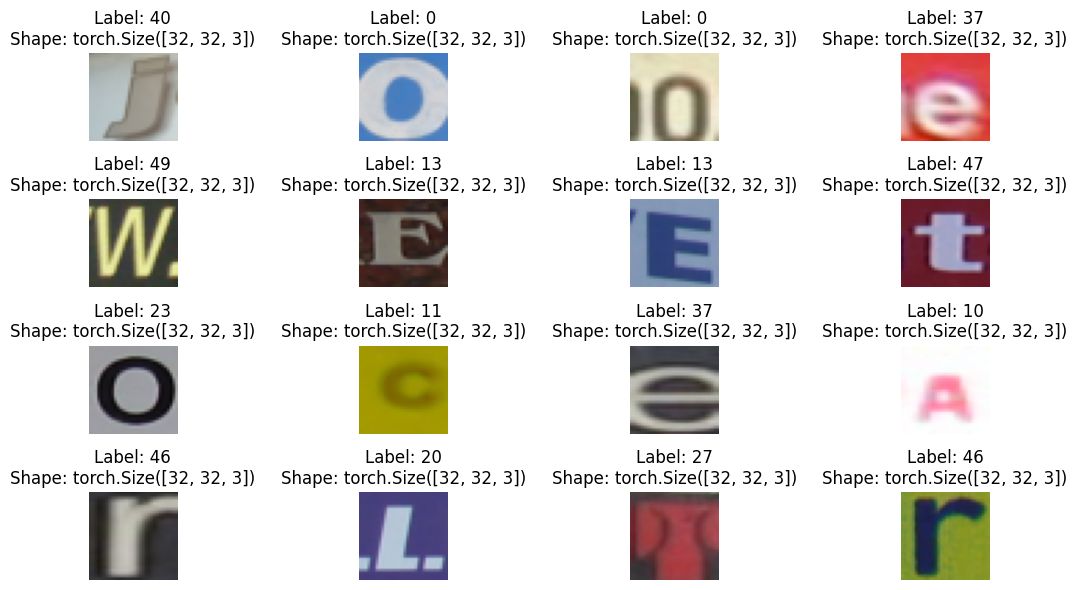

In [ ]:
import random

fig, axes = plt.subplots(4, 4, figsize=(12, 6))
axes = axes.flatten()
random.seed(123)
random_indices = random.sample(range(len(trainData)), 16)

for i, index in enumerate(random_indices):
    image, label = trainData[index]
    print(image, label, i, index)
    image = deNormalize(image, mean_rgb, std_rgb)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)

    axes[i].imshow(image)

    axes[i].set_title(f"Label: {label}\nShape: {image.shape}")
    axes[i].axis("off")


plt.tight_layout()
plt.show()


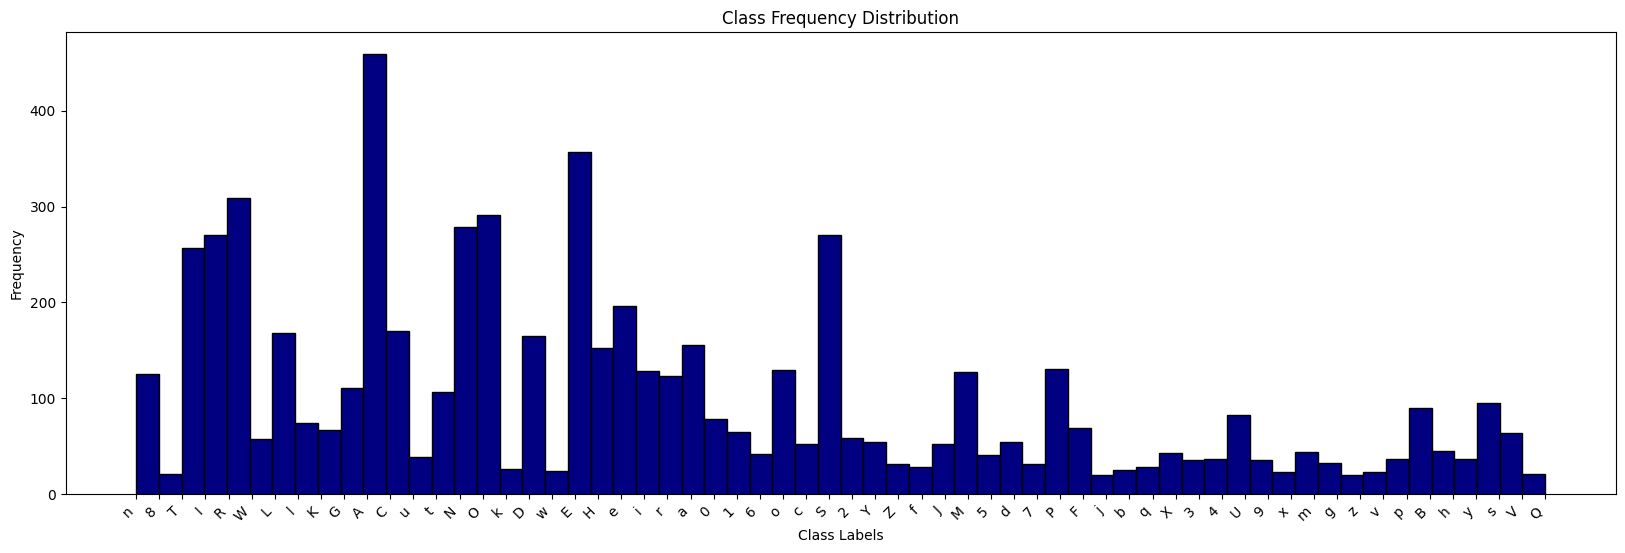

In [ ]:
# Load the CSV file
df = pd.read_csv(baseDir + 'trainLabels.csv')
labels = df['Class']


# Plot the frequencies
plt.figure(figsize=(20, 6))
plt.hist(labels, bins = len(set(labels)),color='navy', edgecolor='black')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

# Model

In [ ]:
def createNet():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()

            ### Feature Maps
            kernalSize = [3, 3]
            self.conv1 = nn.Conv2d(3, 64, kernalSize, padding=1)
            self.batchNorm1 = nn.BatchNorm2d(64)
            outSize = (imgSize + 2 * self.conv1.padding[0] - kernalSize[0] + 1) // 2

            self.conv2 = nn.Conv2d(64, 128, kernalSize, padding=1)
            self.batchNorm2 = nn.BatchNorm2d(128)
            outSize = (outSize + 2 * self.conv2.padding[0] - kernalSize[0] + 1) // 2

            self.conv3 = nn.Conv2d(128, 256, kernalSize, padding=1)
            self.batchNorm3 = nn.BatchNorm2d(256)
            outSize = (outSize + 2 * self.conv3.padding[0] - kernalSize[0] + 1) // 2

            self.conv4 = nn.Conv2d(256, 512, kernalSize, padding=1)
            self.batchNorm4 = nn.BatchNorm2d(512)
            outSize = (outSize + 2 * self.conv4.padding[0] - kernalSize[0] + 1) // 2

            self.conv5 = nn.Conv2d(512, 1024, kernalSize, padding=1)
            self.batchNorm5 = nn.BatchNorm2d(1024)
            outSize = (outSize + 2 * self.conv5.padding[0] - kernalSize[0] + 1) // 2



            ### Linear Layers

            self.fc1 = nn.Linear(outSize * outSize * self.conv5.out_channels, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, 256)
            self.fc4 = nn.Linear(256, 62)

        def forward(self, x):
            ### Convulation Operations
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.relu(self.batchNorm1(x))

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.relu(self.batchNorm2(x))

            x = F.max_pool2d(self.conv3(x), 2)
            x = F.relu(self.batchNorm3(x))

            x = F.max_pool2d(self.conv4(x), 2)
            x = F.relu(self.batchNorm4(x))

            x = F.max_pool2d(self.conv5(x), 2)
            x = F.relu(self.batchNorm5(x))


            ### Linear Layers
            x = x.reshape(x.shape[0], -1)

            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=0.1, training=self.training)

            x = F.relu(self.fc2(x))
            x = F.dropout(x, p=0.1, training=self.training)

            x = F.relu(self.fc3(x))
            x = F.dropout(x, p=0.1, training=self.training)

            x = self.fc4(x)

            return x

    net = Net()
    lossFun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    return net, lossFun, optimizer


In [ ]:
net, lossFun, optimizer = createNet()
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3          [-1, 128, 16, 16]          73,856
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 256, 8, 8]         295,168
       BatchNorm2d-6            [-1, 256, 4, 4]             512
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
       BatchNorm2d-8            [-1, 512, 2, 2]           1,024
            Conv2d-9           [-1, 1024, 2, 2]       4,719,616
      BatchNorm2d-10           [-1, 1024, 1, 1]           2,048
           Linear-11                 [-1, 1024]       1,049,600
           Linear-12                  [-1, 512]         524,800
           Linear-13                  [-1, 256]         131,328
           Linear-14                   

# Test

In [ ]:
def testNet(net, lossFun, optimizer, testLoader):
    net.eval()
    matches = 0
    for data, labels in testLoader:
        # print(labels)
        if device != 'cpu':
            data = data.to(device)
            labels = labels.to(device)
        with torch.no_grad():
            pred = net(data)
        if device != 'cpu':
            labels = labels.to(device)
            pred = pred.to(device)
        # print(pred)
        pred = torch.argmax(pred, axis=1)
        matches += (pred == labels).sum().item()
    # print(matches)
    acc = 100 * matches / len(testLoader.dataset)

    return acc

In [ ]:
testNet(net, lossFun, optimizer, testLoader)

0.1589825119236884

# Train

In [ ]:
def trainNet(net, lossFun, optimizer, trainLoader):
    epochs = 50

    timeStart = time.process_time()
    timeNow = timeStart

    trainAcc = []
    trainLoss = []
    testAcc = []

    for epoch in range(epochs):

        net.train()

        batchAcc = []
        batchLoss = []

        for data, labels in trainLoader:

            if device != "cpu":
                data = data.to(device)
                labels = labels.to(device)

            ## Calculate forward pass and loss
            pred = net(data)
            loss = lossFun(pred, labels)

            ## backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## accurecy and loss
            pred = pred.cpu()
            labels = labels.cpu()
            matches = (torch.argmax(pred, axis=1) == labels).float()
            acc = 100 * torch.mean(matches)

            batchAcc.append(acc)
            batchLoss.append(loss.item())
            # print(acc, epoch)

        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        testAcc.append(testNet(net, lossFun, optimizer, testLoader))

        timeTaken = time.process_time() - timeNow
        elapsedTime = time.process_time() - timeStart
        timeNow = time.process_time()

        print(f"Epoch {epoch+1}/{epochs}, time taken: {timeTaken:.2f}, Lelapsed time: {elapsedTime:.2f} sec, test accuracy {testAcc[-1]:.4f}%")

    return trainAcc, testAcc, trainLoss


# Main


In [ ]:
# trainAcc, testAcc, trainLoss = trainNet(net, lossFun, optimizer, trainLoader)

In [ ]:
# fig, aa = plt.subplots(1, 2, figsize = (16, 5))

# aa[0].plot(trainLoss)
# aa[0].set_ylim(0, 100)

# aa[1].plot(trainAcc)
# aa[1].plot(testAcc)

# plt.show()

In [ ]:
# torch.save(net.state_dict(), baseDir + 'characterRecognition.pt')

In [ ]:
net = createNet()[0]
net.load_state_dict(torch.load(baseDir + 'characterRecognition.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
net.to(device)
acc = testNet(net, lossFun, optimizer, testLoader)
print(f'test accuracy {acc:.4f}%')

test accuracy 71.8601%


In [ ]:
class ImageDatasetTest(Dataset):
    def __init__(self, imgDir, transform=None):
        self.imgDir = imgDir
        self.transform = transform
        # Get a list of all image files in the dir
        self.image_files = sorted(
            [f for f in os.listdir(imgDir) if f.endswith(".Bmp")],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        # print(self.image_files)
        # Load all images into memory using parallel processing
        self.images = [None] * len(self.image_files)
        with ThreadPoolExecutor() as executor:
            executor.map(self.loadImage, range(len(self.image_files)))

    def loadImage(self, idx):
        imgPath = os.path.join(self.imgDir, self.image_files[idx])
        image = Image.open(imgPath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        self.images[idx] = image

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image

In [ ]:
# datasetTest = ImageDatasetTest(baseDir + 'test', transform)
# torch.save(datasetTest, baseDir + 'charDatasetTest.pt')

torch.serialization.add_safe_globals([ImageDatasetTest])
datasetTest = torch.load(baseDir + 'charDatasetTest.pt')

testLoader1 = DataLoader(datasetTest, batch_size=1024, shuffle=False)

In [ ]:
datasetTest

In [ ]:
net.eval()
pred = []
with torch.no_grad():
  for x in testLoader1:
    x = x.to(device)
    pred.append(net(x).cpu())
pred1 = pred

In [ ]:
pred = pred1
pred = [torch.argmax(t, axis = 1) for t in pred]
pred = torch.cat(pred)
pred.shape

torch.Size([6220])

In [ ]:
alphabet = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
pred = [alphabet[val] for val in pred.tolist()]

In [ ]:
df = pd.DataFrame(pred, columns=['Class'])
df.index = np.arange(6284, len(df) + 6284)
df.index.name = 'ID'
df.head()

,Class
ID,
6284,H
6285,E
6286,I
6287,O
6288,T


In [ ]:
df.to_csv(baseDir + 'pred0.csv', index = True)

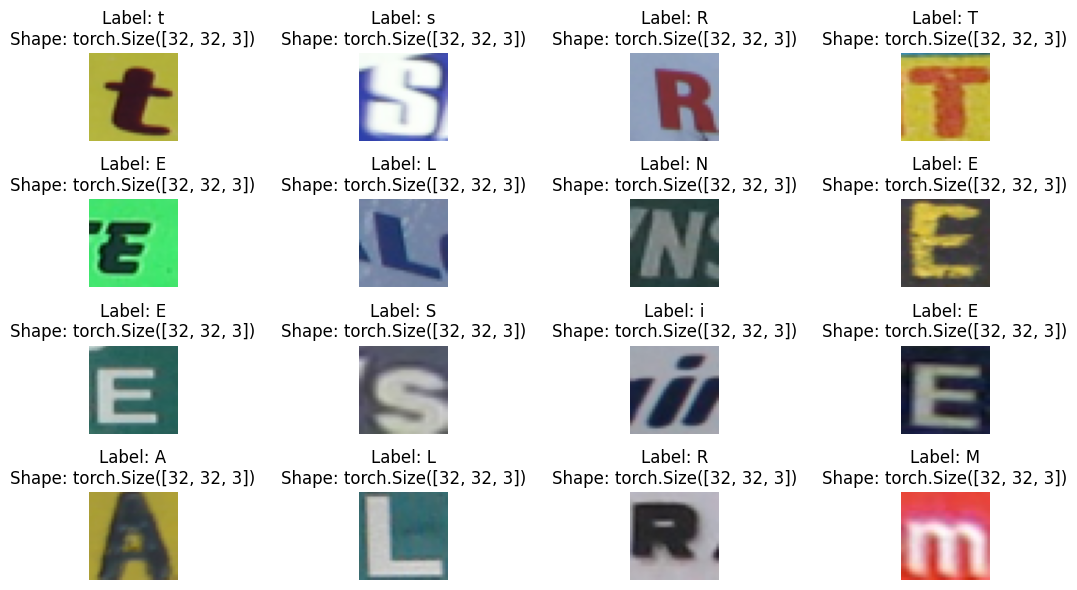

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12, 6))
axes = axes.flatten()
random.seed(3423)
random_indices = random.sample(range(len(datasetTest)), 16)

for i, index in enumerate(random_indices):
    image = datasetTest[index]
    label = df.iloc[index, 0]
    image = deNormalize(image, mean_rgb, std_rgb)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)

    axes[i].set_title(f"Label: {label}\nShape: {image.shape}")
    axes[i].axis("off")


plt.tight_layout()
plt.show()